In [20]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, make_scorer, accuracy_score
from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
dfr = pd.read_csv('./data/winequality-red.csv', sep=';')
target = 'quality'

### Splitting target and features

In [3]:
X = dfr.drop(columns=[target])
y = dfr[target]

### Splitting to train and test - We split 75% to train, and we stratify to balance the minority classes in the training and test set

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

### This function will help us understand if we improved after each step

In [5]:
def calculate_scores(y_true, y_pred, image_name = None):
    report = classification_report(
    y_true, y_pred, target_names=['3', '4', '5', '6', '7', '8'], output_dict=True
    )

    df_report = pd.DataFrame(report).transpose()

    df_report = df_report.drop(columns=['support'], errors='ignore')

    plt.figure(figsize=(10, 6))
    sns.heatmap(
        df_report.iloc[:-1, :].astype(float),
        annot=True, cmap="YlGnBu", cbar=True, fmt=".2f", linewidths=0.5,
    )

    plt.title('Figure 8: Classification Report', fontsize=16, weight='bold')
    plt.xlabel('Metrics', fontsize=14)
    plt.ylabel('Classes', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.tight_layout()

    if image_name:
        plt.savefig(f'./images/{image_name}', dpi=300, bbox_inches='tight')

    plt.show()


# Basic Pipeline:

In [6]:
def basic_pipeline(X_train, y_train):
    model = XGBRegressor()

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    return y_pred

In [7]:
def round_results(y_pred):
    #To get the actual qualitys
    y_pred_rounded = np.array([])
    for pred in y_pred:
        y_pred_rounded = np.append(y_pred_rounded, round(pred))

    y_pred_indexed = pd.Series(y_pred_rounded, y_test.index)

    return y_pred_indexed

In [8]:
y_pred_basic = basic_pipeline(X_train, y_train)

### Simply rounding the results

In [9]:
y_pred_basic_rounded = round_results(y_pred_basic)

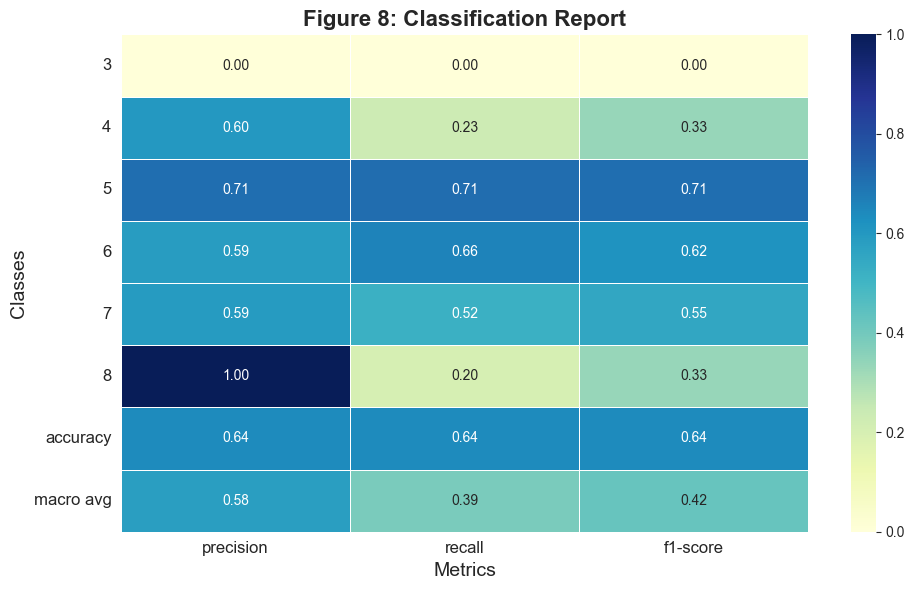

In [10]:
calculate_scores(y_test, y_pred_basic_rounded, 'basic-pipline-results')

 Key Takeaways from the Classification Report

## Class Performance:
- **Class 3:**
  - Poor performance with all metrics (`precision`, `recall`, and `f1-score`) being **0**.
  - The model failed to correctly classify any instances of this class.

- **Class 4:**
  - Struggles with low `precision` (**0.50**), `recall` (**0.23**), and `f1-score` (**0.32**).
  - Indicates difficulty in identifying this class correctly.

- **Class 5:**
  - Fairly balanced performance with `precision` (**0.70**), `recall` (**0.69**), and `f1-score` (**0.70**).
  - Shows reasonable performance for this class.

- **Class 6:**
  - Slightly better `recall` (**0.71**) but a moderate `f1-score` (**0.66**).
  - Indicates some imbalance in predictions.

- **Class 7:**
  - Moderate results with `precision` (**0.63**) but lower `recall` (**0.48**), leading to an `f1-score` of **0.55**.

- **Class 8:**
  - Perfect `precision` (**1.00**) but poor `recall` (**0.20**), resulting in a low `f1-score` (**0.33**).
  - Suggests overconfidence with very few true positives.

## Aggregate Metrics:
- **Accuracy:**
  - The overall accuracy is **0.65**, meaning roughly two-thirds of predictions were correct.

- **Macro Average:**
  - `Precision` (**0.57**), `recall` (**0.39**), and `f1-score` (**0.42**) reflect significant disparity in class-wise performance.

## Areas for Improvement:
- Significant attention is needed for **Class 3** and **Class 4**, as their metrics are substantially low.
- **Class 8** demonstrates overconfidence with high `precision` but very low `recall`, suggesting missed true positives.
- Balancing class-wise performance is critical, as shown by the discrepancy between the macro averages and overall accuracy.

## Balanced Classes:
- **Class 5** and **Class 6** exhibit the most balanced performance among the classes, indicating better predictability.

By addressing the weaknesses in specific classes, the overall performance of the classification model can be improved.


# Feature Engineering:

### Alcohol * Density

Based on the formula for density, the alcohol content in terms of mass can be calculated by multiplying the alcohol percentage by volume with the corresponding density. This calculation introduces a new feature, named alcohol_density, which may provide additional insights into the dataset.

In [11]:
X['alcohol density'] = X['alcohol'] * X['density']

## Total Acidity

Acidity, determined by the total sum of acids in a sample, is a key indicator of wine balance during winemaking. It is quantified as the sum of `fixed_acidity`, `volatile_acidity`, and `citric_acid`:

- **`fixed_acidity`**: Low-volatility organic acids like malic, lactic, tartaric, and citric acids, inherent to the sample's characteristics.
- **`volatile_acidity`**: Short-chain organic acids (e.g., formic, acetic, propionic, butyric acids) extractable via distillation.


In [12]:
X['total acidity'] = X['volatile acidity'] + X['fixed acidity'] + X['citric acid']

# experimenting with this feature
X['percent acidity'] = (X['volatile acidity'] / (X['fixed acidity']) + X['citric acid'])
print('Correlation with the target feature:')
print('total acidity', np.corrcoef(X['total acidity'], y)[0][1])
print('percent acidity', np.corrcoef(X['percent acidity'], y)[0][1])
print('volatile acidity', np.corrcoef(X['volatile acidity'], y)[0][1])
print('fixed acidity', np.corrcoef(X['fixed acidity'], y)[0][1])
print('citric acid', np.corrcoef(X['citric acid'], y)[0][1])

Correlation with the target feature:
total acidity 0.10375372825598397
percent acidity 0.19546266788359346
volatile acidity -0.39055778026400734
fixed acidity 0.1240516491132243
citric acid 0.22637251431804142


## Ideal ph Level

According to this [source](https://morewinemaking.com/articles/testing_wine_must), the ideal ph level for red wine should be around the 3.4 to 3.6 range. A `pH` above 3.6 indicates and unstable wine and will not have a long shelf life. pH under 3.4 generally indicates a wine that will be too sour. This may serve as a relevant indicator of what differentiated a good from a bad red wine.

In [13]:
X['ideal ph'] = 0
X.loc[(X['pH'] >= 3.4) & (X['pH'] <= 3.65), 'ideal ph'] = 1
print('Correlation with the target feature:')
print('ideal ph', np.corrcoef(X['ideal ph'], y)[0][1])
print('pH', np.corrcoef(X['pH'], y)[0][1])

Correlation with the target feature:
ideal ph -0.04809480006463274
pH -0.05773139120538215


## Acidity * ph

In [14]:
X['ph acidity'] = X['pH'] * X['percent acidity']
print('Correlation with the target feature:')
print('ph acidity', np.corrcoef(X['ph acidity'], y)[0][1])
print('pH', np.corrcoef(X['pH'], y)[0][1])
print('percent acidity', np.corrcoef(X['percent acidity'], y)[0][1])

Correlation with the target feature:
ph acidity 0.19678899392992688
pH -0.05773139120538215
percent acidity 0.19546266788359346


## Percent Free SO2

`sulfur_dioxide` is used in winemaking as a preservative to prevent oxidation and microbial spoilage. It exists in three forms; bisulfite (HSO3-), molecular SO2, and sulfite (SO32). The equilibrium is pH dependent with the predominate form at wine pH being bisulfite. Most of the rest is molecular and very little, if any, remains in sulfite form. These forms make up what is termed as `free_sulfur_dioxide`. `free_sulfur_dioxide` can be lost through volatilization or binding, thus management is important.


In [15]:
X['percent free sulfur'] = X['free sulfur dioxide'] / X['total sulfur dioxide']
print('Correlation with the target feature:')
print('percent free sulfur', np.corrcoef(X['percent free sulfur'], y)[0][1])
print('total sulfur dioxide', np.corrcoef(X['total sulfur dioxide'], y)[0][1])
print('free sulfur dioxide', np.corrcoef(X['free sulfur dioxide'], y)[0][1])

Correlation with the target feature:
percent free sulfur 0.194113350747308
total sulfur dioxide -0.18510028892653785
free sulfur dioxide -0.05065605724427633


## To improve our model, we change our classes to range from 0-5 instead of 3-8

In [16]:
y = y - 3

## Custom loss function

We are going to make our model use the softprob objective, meaning it will return the confidence level of the predictions. For this reason and because we have a very low number of labels, we will provide a custom loss function that takes the highest probability of a label and calculates the overall accuracy.

In [17]:
def wine_quality_loss_func(y_true, y_pred):
    y_pred_labels = np.argmax(y_pred, axis=1)
    return accuracy_score(y_true, y_pred_labels)

## Balancing the data:

We have imbalanced data, we have a lot of classes for wines rated at 5-6, small amount of samples for wines rated 4 & 7, and almost no samples for wines rated at 3 & 8, we clearly saw this from the classification results table above. To fix this, we will use SMOTE and balance our classes

In [18]:
sm = SMOTE(random_state=42)

X_res, y_res = sm.fit_resample(X, y)

## Resplitting the data:

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.25, random_state=42, stratify=y_res)

# Improved pipeline:

We continue to use the xgboost regressor, like in EX1. This time we specify parameters for the model:

1. The number of classes is 6
2. The objective of the model is softprob, returning the confidence level of the predictions.
3. For evaluation metric, Mlogloss is perfect, Mlogloss measures the dissimilarity between the predicted class probabilities and the actual class labels, with lower values indicating better performance.

Then, we search for the best parameters, this includes:
1. max_depth - Controls the complexity of the model: deeper trees can capture more complex patterns but may lead to overfitting.
2. n_estimatos - Determines the ensemble size: more trees generally improve performance but increase computation time and risk of overfitting.
3. learning_rate - Lower values make the training process slower and more stable, while higher values speed up training but might miss optimal solutions.
4. reg_alpha - Encourages sparsity in the feature weights, which can help when dealing with high-dimensional or noisy data.
5. reg_lambda - Reduces the impact of individual features with large weights, helping to control overfitting.

In [ ]:
param_grid = {
    'max_depth': [14,16,18],
    'n_estimators': [120,140,160,180,200,220],
    'learning_rate': [0.01, 0.05, 0.1],
    # 'reg_alpha': [0, 0.1, 0.5, 1],
    # 'reg_lambda': [0,1,2,5]
}

xgboost = XGBRegressor(objective="multi:softprob", num_class=6,eval_metric="mlogloss",random_state = 42)

scorer = make_scorer(wine_quality_loss_func, greater_is_better=True)

grid_search = GridSearchCV(estimator=xgboost, param_grid=param_grid, n_jobs=-1, cv=5, verbose=10, scoring=scorer)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


In [ ]:
model = grid_search.best_estimator_
y_proba = model.predict(X_test)

y_pred = np.argmax(y_proba, axis=1)

calculate_scores(y_test, y_pred, 'improved-pipeline-results')

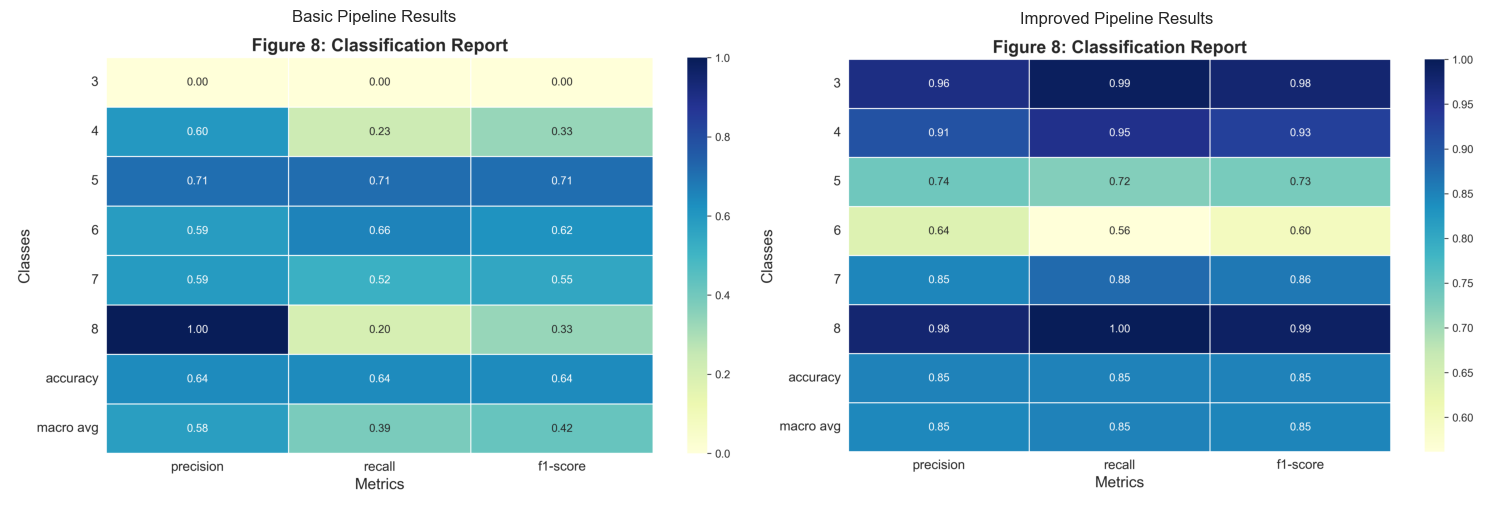

In [25]:
basic_pipeline_results = mpimg.imread('./images/basic-pipline-results.png')
improved_pipeline_results = mpimg.imread('./images/improved-pipeline-results.png')

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].imshow(basic_pipeline_results)
axes[0].axis('off')  # Hide the axes
axes[0].set_title('Basic Pipeline Results')

# Display the second image
axes[1].imshow(improved_pipeline_results)
axes[1].axis('off')  # Hide the axes
axes[1].set_title('Improved Pipeline Results')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


# Results

### Key Takeaways: Pipeline Improvement

1. **Overall Performance:**
   - **Basic Pipeline:** Lower metrics across the board, with macro-average scores:
     - Precision: ~0.58
     - Recall: ~0.39
     - F1-score: ~0.42
   - **Improved Pipeline:** Significantly higher metrics:
     - Precision: ~0.85
     - Recall: ~0.85
     - F1-score: ~0.85

2. **Class-Specific Improvements:**
   - **Class 3:**
     - Basic Pipeline: Near-zero performance for all metrics.
     - Improved Pipeline: Precision (0.96), Recall (0.99), F1-score (0.98), showing near-perfect results.
   - **Class 8:**
     - Basic Pipeline: Precision (1.0), but low Recall (0.20), leading to a poor F1-score.
     - Improved Pipeline: Well-balanced performance with Precision (0.98), Recall (1.00), and F1-score (0.99).
   - Significant improvements are also observed in **Classes 4** and **7**, with much higher recall and F1-scores.

3. **Accuracy:**
   - Basic Pipeline: 0.64
   - Improved Pipeline: 0.85 (substantial improvement in overall correctness). A 33% improvement

4. **Metric Balance:**
   - **Basic Pipeline:** Noticeable imbalance between precision and recall, resulting in poor F1-scores.
   - **Improved Pipeline:** Better alignment between precision and recall, yielding consistently higher F1-scores.

5. **Common Classes:**
    In the improved pipeline, we can see the results for the common class are a bit wierd, for class 5 we did improve the results. For class 6, the precision went up, but the accuracy and f1-score went down a little bit, this happend because we used SMOTE. It's normal to see a trade-off when you apply SMOTE or any method aimed at boosting minority classes. By giving extra attention (and synthetic samples) to the underrepresented classes, the model may shift some of its decision boundary away from the majority classes.



